In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm 
import time
import os
from PIL import Image
import cv2 
from model import ContrastiveLoss
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
#from albumentations.augmentations.transforms import HorizontalFlip,VerticalFlip

%matplotlib inline

In [2]:
class TwinPairsDataset(Dataset):
    def __init__(self, dataroot, df_pairs, df_views, transform, keypoints=False):
        '''
        dataroot: path to folder with items
        df_pairs: pd dataframe containing pairs of ids and a correspodind label:
                    'Same', 'Fraternal', 'Identical', 'UnknownTwinType',
                    'IdenticalMirror', 'Sibling', 'IdenticalTriplet'
        df_views: pd dataframe containing list of available for each id in the dataset                    
        transform: torchvision transform
        '''
        self.dataroot = dataroot
        self.df_pairs = df_pairs
        self.df_views = df_views
        self.transform = transform
        self.keypoints = keypoints
        
    def __getitem__(self, index):
        sample={}
        
        id_1, id_2  = self.df_pairs.iloc[index][['id_1', 'id_2']].values
        id_1 = str(id_1)
        id_2 = str(id_2)
        label = int(self.df_pairs.iloc[index].label=='Same')
        if id_1==id_2:
             view_1, view_2 = np.random.choice(self.df_views.loc[id_1]['filename'], size=2, replace=False) 
        else:
            view_1 = np.random.choice(self.df_views.loc[id_1]['filename'])
            view_2 = np.random.choice(self.df_views.loc[id_2]['filename'])

        path_1 = os.path.join(self.dataroot, id_1, view_1)
        path_2 = os.path.join(self.dataroot, id_2, view_2)
        
        img_1 = Image.open(path_1)
        img_2 = Image.open(path_2)
        if self.keypoints:
            df_keypoints=pd.read_csv(self.dataroot+'/df/aligned_landmarks.csv')
            df_flip_keypoints=pd.read_csv(self.dataroot+'/df/aligned_FLIP_landmarks.csv')
            
            if id_1==id_2:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2 = df_flip_keypoints[view_2].values
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
                
            else:
                keypoints_1 = df_keypoints[view_1].values
                keypoints_2 = df_keypoints[view_2].values
                keypoints_1=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_1])
                keypoints_2=np.array([ [int(t[1:-1].split(', ')[0]),int(t[1:-1].split(', ')[1])] for t in keypoints_2])
            sample['keypoints_1'] = keypoints_1
            sample['keypoints_2'] = keypoints_2
        
        if label==1:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['same'](img_2)
        else:
            img_1 = self.transform['twin'](img_1)
            img_2 = self.transform['twin'](img_2)
            
        sample['img_1']=img_1
        sample['img_2']=img_2
        sample['label']=label
        
        return sample
    
    def __len__(self):
        return self.df_pairs.shape[0]

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform ={
    'same': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(p=1),
            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'twin': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                }
views = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/pairs_train.csv')

direct='/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/'
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)
dataloader = DataLoader(dataset, batch_size=10,shuffle=True)

## Train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


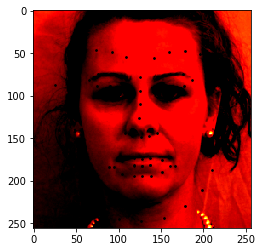

In [4]:
idx = 119

sample = dataset[idx]
std=sample['img_1'].numpy().std()
mean=sample['img_1'].numpy().mean()
plt.imshow(sample['img_1'].numpy().transpose(1,2,0)*std+mean)
kp = sample['keypoints_1']
plt.scatter(kp[:,0], kp[:,1], s=3,color='black')
plt.show()

In [5]:
from model import MobileFaceNet

model = MobileFaceNet(embedding_size=512)

PATH = os.path.join(os.getcwd(),"./model_mobilefacenet.pth")

checkpoint = torch.load(PATH,map_location=device)

model.load_state_dict(checkpoint)
optimizer = optim.SGD(model.parameters(),lr=0.1)

#### Load pretrained model

In [6]:
class ModelBottom(nn.Module):
    def __init__(self, original_model):
        super(ModelBottom, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        output = self.features(x)
        return output

#define model and fix hidden features size
model_flatten = ModelBottom(model)
T=next(iter(dataloader))
outputs = model_flatten(T['img_2'])
hid_size=outputs.data.shape[1]

#define n_classes
classes=os.listdir(direct)
n_classes=len(classes)

#define classifier
model_flatten_classifier = nn.Sequential(
                      nn.Linear(hid_size, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.3),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))

# concatenate conv MobileFaceNet and classifier
class FinModel(nn.Module):
    def __init__(self,flatten_model,classifier_model):
        super(FinModel, self).__init__()
        self.to_flat_model=flatten_model
        self.classifier_model=classifier_model
    def forward(self,x):
        outputs=self.to_flat_model(x)
        outputs=self.classifier_model(outputs)
        return outputs
for param in model_flatten.parameters():
    param.requires_grad = False

In [7]:
class myModel(nn.Module):
        def __init__(self):
            super(myModel,self).__init__()
            self.model_start = model_flatten
            self.fc_layers = nn.Sequential(
                      nn.Linear(hid_size, 500),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True), 
                      nn.Linear(500,5),
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True))
   	    
        def forward(self,x):
            out1 = self.model_start(x)
            return self.fc_layers(out1)

In [8]:
model_final = myModel()

In [9]:
def train(output_path, model, dataloader, optimizer,criterion, device, n_epochs=100):
    model.cuda(device)
    loss_hist=[]
    for epoch in range(n_epochs):
        loss_epoch = 0
        for i,batch_item in enumerate(dataloader):
            result_img_a=model(batch_item['img_1'].cuda(device))
            result_img_b=model(batch_item['img_2'].cuda(device))
            label=batch_item['label']
            loss_batch=0
            loss=0
            optimizer.zero_grad()
            
            for j in range(result_img_a.shape[0]):
                loss += criterion(result_img_a[j][None],result_img_b[j][None],label[j])        
            loss_batch+=loss.detach().cpu().item()
            if i % 100 == 0: print("Loss_batch={}".format(loss_batch))
            loss.backward(retain_graph=True)
            optimizer.step()
            loss_epoch+=loss_batch
           
           
        loss_hist.append(loss_epoch)
        torch.save(model.state_dict(), os.path.join(os.getcwd(),str(output_path)) + '/{}_epoch.pt'.format(epoch+1))
        plt.plot(loss_hist) 
        plt.title('loss')
        plt.legend()
        plt.show()    
    model.eval()

Loss_batch=14.895437240600586


No handles with labels found to put in legend.


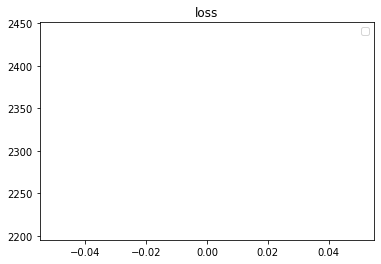

Loss_batch=35.999916076660156


No handles with labels found to put in legend.


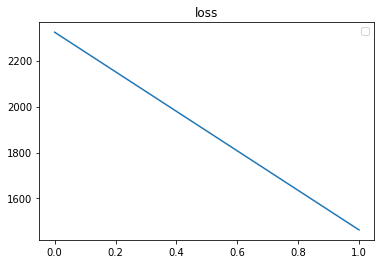

Loss_batch=19.999954223632812


No handles with labels found to put in legend.


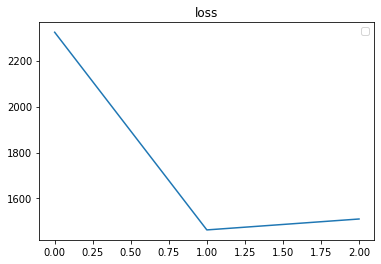

Loss_batch=23.99994468688965


No handles with labels found to put in legend.


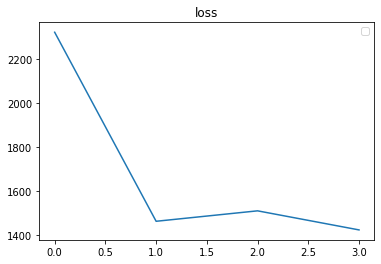

Loss_batch=19.999954223632812


No handles with labels found to put in legend.


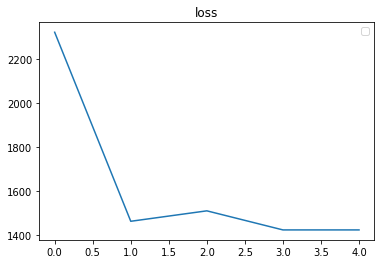

Loss_batch=31.99992561340332


No handles with labels found to put in legend.


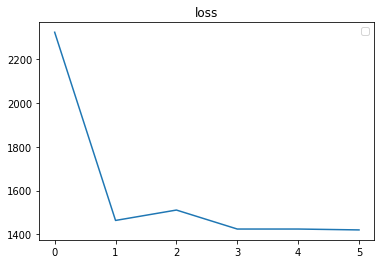

Loss_batch=15.999963760375977


No handles with labels found to put in legend.


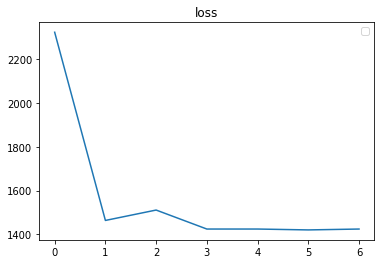

Loss_batch=19.999954223632812


No handles with labels found to put in legend.


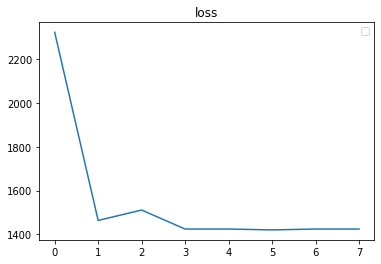

Loss_batch=19.999954223632812


KeyboardInterrupt: 

In [10]:
model_final = myModel()
optimizer = optim.Adam(model_final.parameters(),lr = 0.0005)
criterion=ContrastiveLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train("mobile_chkpts",model_final,dataloader,optimizer,criterion,device,n_epochs=20)

### validation

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_transform ={
    'same': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'twin': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
                }
views = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/df/views.csv', index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv('/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/pairs_test.csv')

direct='/home/khurram/DL_skoltech/Skoltech_DL_2019/Project/Twins/twins_aligned_cropped_resized/'
dataset = TwinPairsDataset(direct, pairs, views,transform=data_transform, keypoints=True)
dataloader_test = DataLoader(dataset, batch_size=10,shuffle=True)

In [16]:
T=next(iter(dataloader_test))
outputs = model_final(T['img_2'].cuda(device))

In [17]:
label = model_final(T['img_2'].cuda(device))

torch.Size([10, 5])

In [ ]:
from sklearn.svm import SVC
